# Table of Contents

- [1. Split training and testing sets](#section1)  
- [2. EDA](#section2) 
- [3. Data Preparation](#section3)
  - [NA Value](#section5)
  - [Bag-of-words Matrix](#section6)
  - [Encoding Categorical Variable](#section7)
  - [Scaling](#section8)
- [4. Feature Selection](#section4)
  - [LASSO](#section9)
  - [Forward Step-Wise](#section10)

- [5. Model Fitting](#section11)
   - [Fitting with LASSO selected design matrix](#section12)
   - [Fitting with foward-stepwise matrix](#section13)
   - [Summarizing Table](#section14) 

- [6. Incorperate unsupervised learning technique](#section15)
   - [Feature Selection](#section16) 
   - [Model Fitting](#section17)
   - [Summarizing Table](#section18)

- [7. Conclusion](#section19)

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.lines import Line2D
import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We first load the data 

In [2]:
data = pd.read_csv('D:/MachineLearning/music prediction/raw_data.csv', index_col = 0,header = 0)

We have a dataset of 10,000 songs and 31 associated features per song

In [3]:
data.head()

,analysis_sample_rate,danceability,duration,end_of_fade_in,energy,key,loudness,mode,start_of_fade_out,tempo,...,tag_top_2,tag_top_3,tag_top_4,tag_top_5,tag_top_6,tag_top_7,tag_top_8,tag_top_9,tag_top_10,year
0,22050,0.0,218.93179,0.247,0.0,1,-11.197,0,218.932,92.198,...,underground rap,g funk,alternative rap,gothic rock,west coast rap,rap,club dance,singer-songwriter,chill-out,0
1,22050,0.0,148.03546,0.148,0.0,6,-9.843,0,137.915,121.274,...,pop rock,blues-rock,beach music,soft rock,soul,classic rock,oldies,power pop,psychedelic rock,1969
2,22050,0.0,177.47546,0.282,0.0,8,-9.689,1,172.304,100.070,...,cumbia,tejano,ranchera,latin pop,latin,tropical,instrumental,christmas music,boleros,0
3,22050,0.0,233.40363,0.000,0.0,0,-9.013,1,217.124,119.293,...,new wave,dance rock,rock,new romantic,europop,beat,british pop,louisiana blues,gothic rock,1982
4,22050,0.0,209.60608,0.066,0.0,2,-4.501,1,198.699,129.738,...,ska punk,breakcore,alternative metal,punk pop,grunge,rock,punk,punk revival,grindcore,2007


We see that there are columns numerical (e.g. danceability, energy, duration) and columns categorical (e.g.artist location, artist name). Below is a preview of the dataset structure showing the data types and completeness of each feature

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   analysis_sample_rate  10000 non-null  int64  
 1   danceability          10000 non-null  float64
 2   duration              10000 non-null  float64
 3   end_of_fade_in        10000 non-null  float64
 4   energy                10000 non-null  float64
 5   key                   10000 non-null  int64  
 6   loudness              10000 non-null  float64
 7   mode                  10000 non-null  int64  
 8   start_of_fade_out     10000 non-null  float64
 9   tempo                 10000 non-null  float64
 10  time_signature        10000 non-null  int64  
 11  artist_familiarity    9996 non-null   float64
 12  artist_hotttnesss     10000 non-null  float64
 13  artist_latitude       3742 non-null   float64
 14  artist_location       10000 non-null  object 
 15  artist_longitude      374

<a id="section1"></a>

# Split training and testing sets

We split training and testing sets before conducting any analysis to ensure that the test set remains unseen during model development

In [5]:
train, test = train_test_split(data, test_size = 0.2, random_state=42)

<a id="section2"></a>

# EDA

We began by exploring potential correlations among the numerical features to better understand the underlying patterns in the data

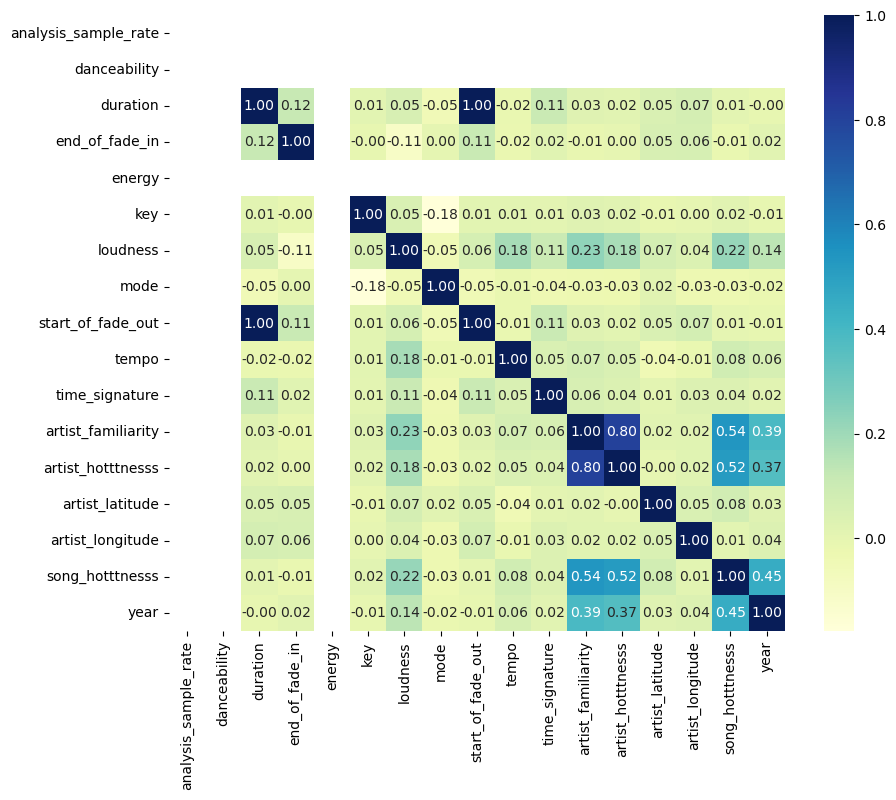

In [6]:
corr_mat = train.corr(numeric_only = True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True, cmap = 'YlGnBu', fmt='.2f', square=True)
plt.show()

Notice that there are empty spaces at the rows and columns of 'analysis_sample_rate', 'danceability' and 'energy', this is bacause these features only contain a single unique value, making them uninformative. These columns were therefore dropped from the dataset.

In [7]:
print(train['danceability'].value_counts(),'\n'), print(train['analysis_sample_rate'].value_counts(),'\n'), 
print(train['energy'].value_counts())

danceability
0.0    8000
Name: count, dtype: int64 

analysis_sample_rate
22050    8000
Name: count, dtype: int64 

energy
0.0    8000
Name: count, dtype: int64


In [8]:
train = train.drop(["danceability", "analysis_sample_rate", "energy"], axis=1)

We also observed a strong collinearity between the pairs 'artist_familiarity' and 'artist_hotttnesss', as well as 'duration' and 'start_of_fade_out' in the pairwised plot. We took a closer look

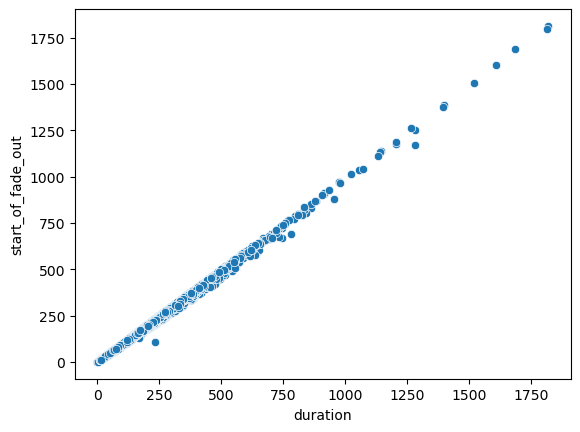

In [9]:
sns.scatterplot(data = train, x='duration', y='start_of_fade_out')
plt.show()

Almost a perfect straight line, we considered to remove the feature 'start_of_fade_out'. For the other pair

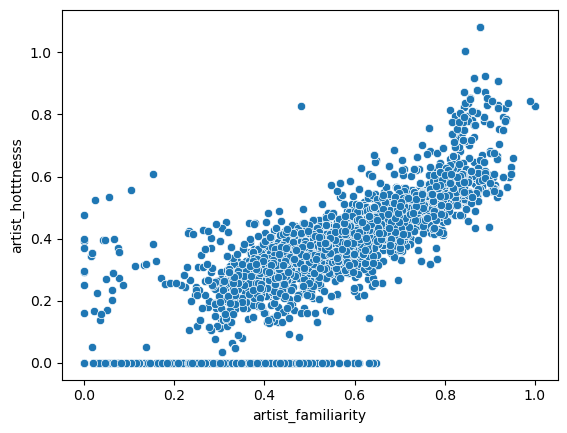

In [10]:
sns.scatterplot(data = train, x='artist_familiarity', y='artist_hotttnesss')
plt.show()

Also an obvious correlation between 'artist_familiarity' and 'artist_hottness' was observed, which aligns with our common sense: artists who are more familiar to the public tend to be more popular 

To settle down potential model fitting problems caused by multicollinearity, we dropped the 'start_of_fade_out' feature and applied a simple transformation into a single feature by averaging them (assuming equal weight):
$$
    \frac{(\mathrm{artist \ hottness} + \mathrm{artist \ familiarity})}{2}
$$

In [11]:
train = train.drop(["start_of_fade_out"], axis=1)
train['artist_hottness_combined'] = (train['artist_familiarity'] + train['artist_hotttnesss'])/2

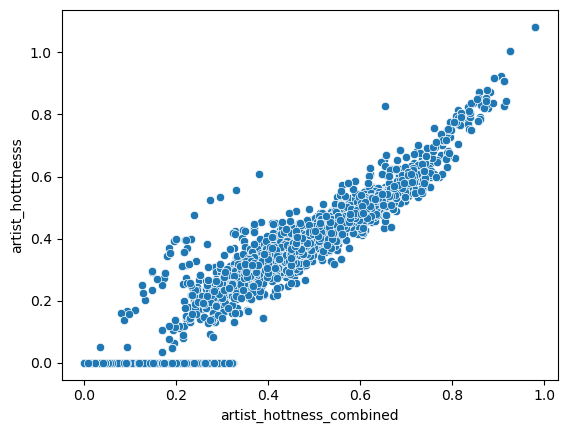

In [12]:
sns.scatterplot(x=train['artist_hottness_combined'], y=train['artist_hotttnesss'])
plt.show()

The correlation between 'song hottness' and the new combined feature seems to be well reserved, so we kept this combination.

In [13]:
train = train.drop(["artist_hotttnesss", "artist_familiarity"], axis=1)

We also explored the geo-locations of the artists, using color to highlight differences in their song hottness.

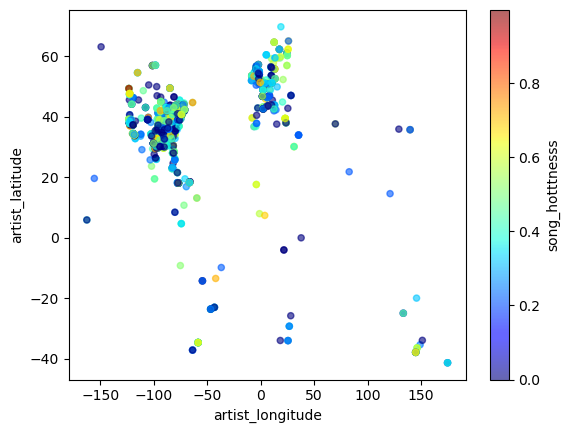

In [14]:
train.plot(kind = 'scatter', x='artist_longitude', y= 'artist_latitude',
          c="song_hotttnesss", cmap=plt.get_cmap("jet"), colorbar=True, alpha = 0.6)
plt.show()

From the plot, we observed that popular songs are more likely to be produced by artists located within certain geographic clusters.

Next, we explored possible data transformations to imporve model performance and ensure feature distributions are suitable for machie learning algorithms.

For numerical features, we examined whether any transformations could be applied to make their distributions more closely resemble a normal distribution.

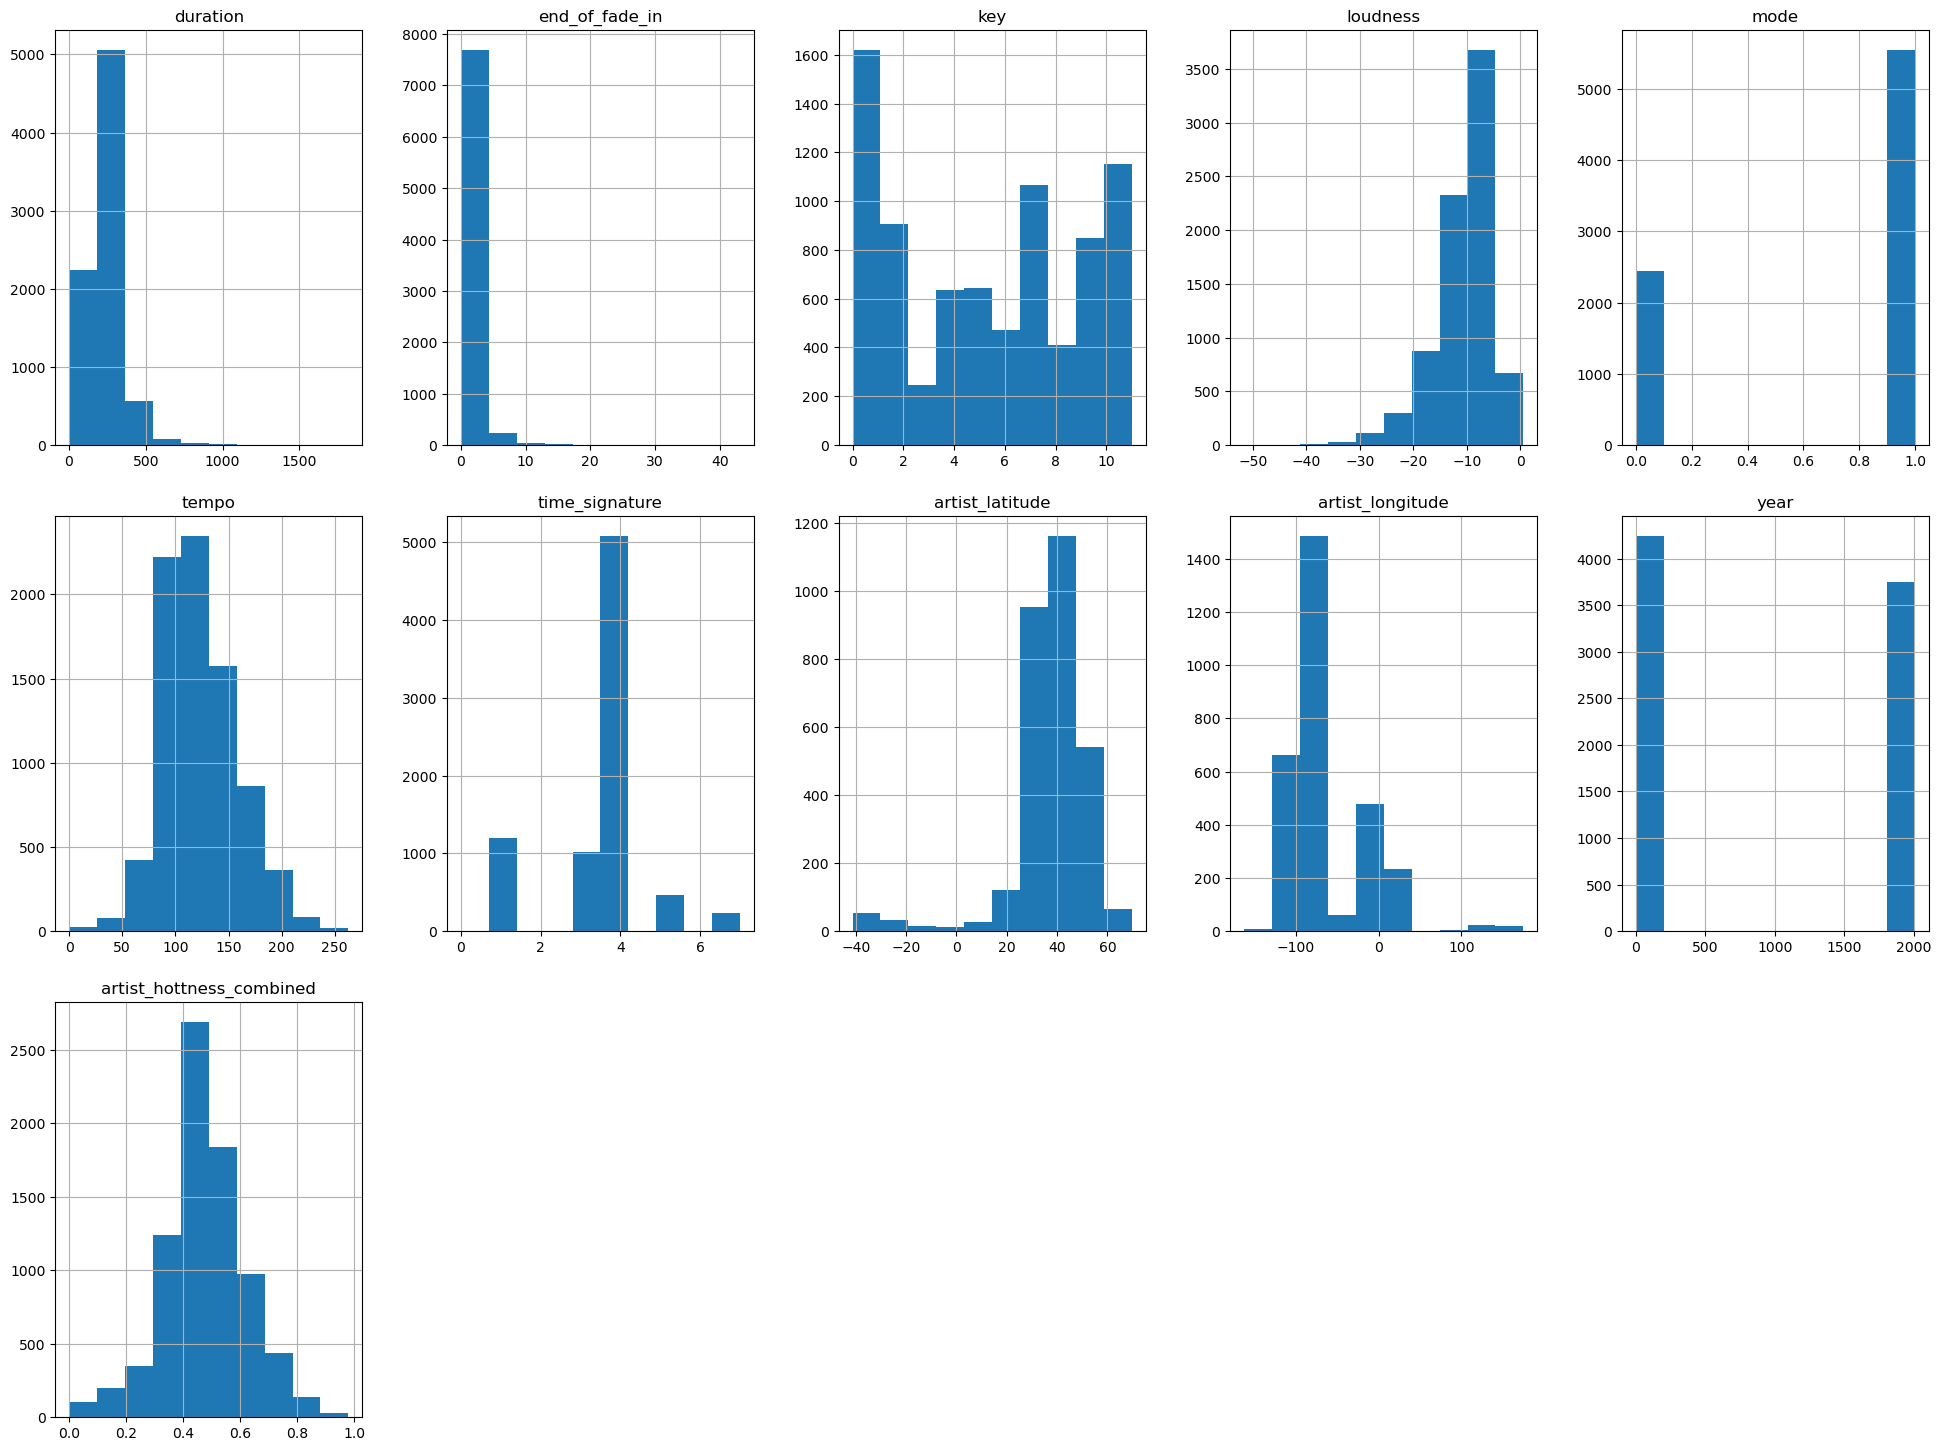

In [15]:
column_names_numeric = train.select_dtypes(include= "number").columns.values
column_names_numeric = column_names_numeric[column_names_numeric != "song_hotttnesss"]

fig, axes = plt.subplots(3,5, figsize=(20,15))
fig.tight_layout(pad=3.0)
axes = axes.flatten()

for i, name in enumerate(column_names_numeric):
    train[name].hist(ax = axes[i])
    axes[i].set_title(name)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

We omit the detailed reasoning behind each transformation and instead present only the resulting distributions of the features

- duration: $x^{1/3}$
- end_of_fade_in: $x^{1/3}$
- loudness: $log(1 + abs(x))$
- tempo: $x$
- artist_latitude: $x$
- artist_longitude: $x$
- year: $x$
- artist_hottness_combined: $x$

In [16]:
train['duration'] = np.power(train['duration'], 1/3)
train['end_of_fade_in'] = np.power(train['end_of_fade_in'], 1/3)
train['loudness'] = np.log(1 + abs(train['loudness']))

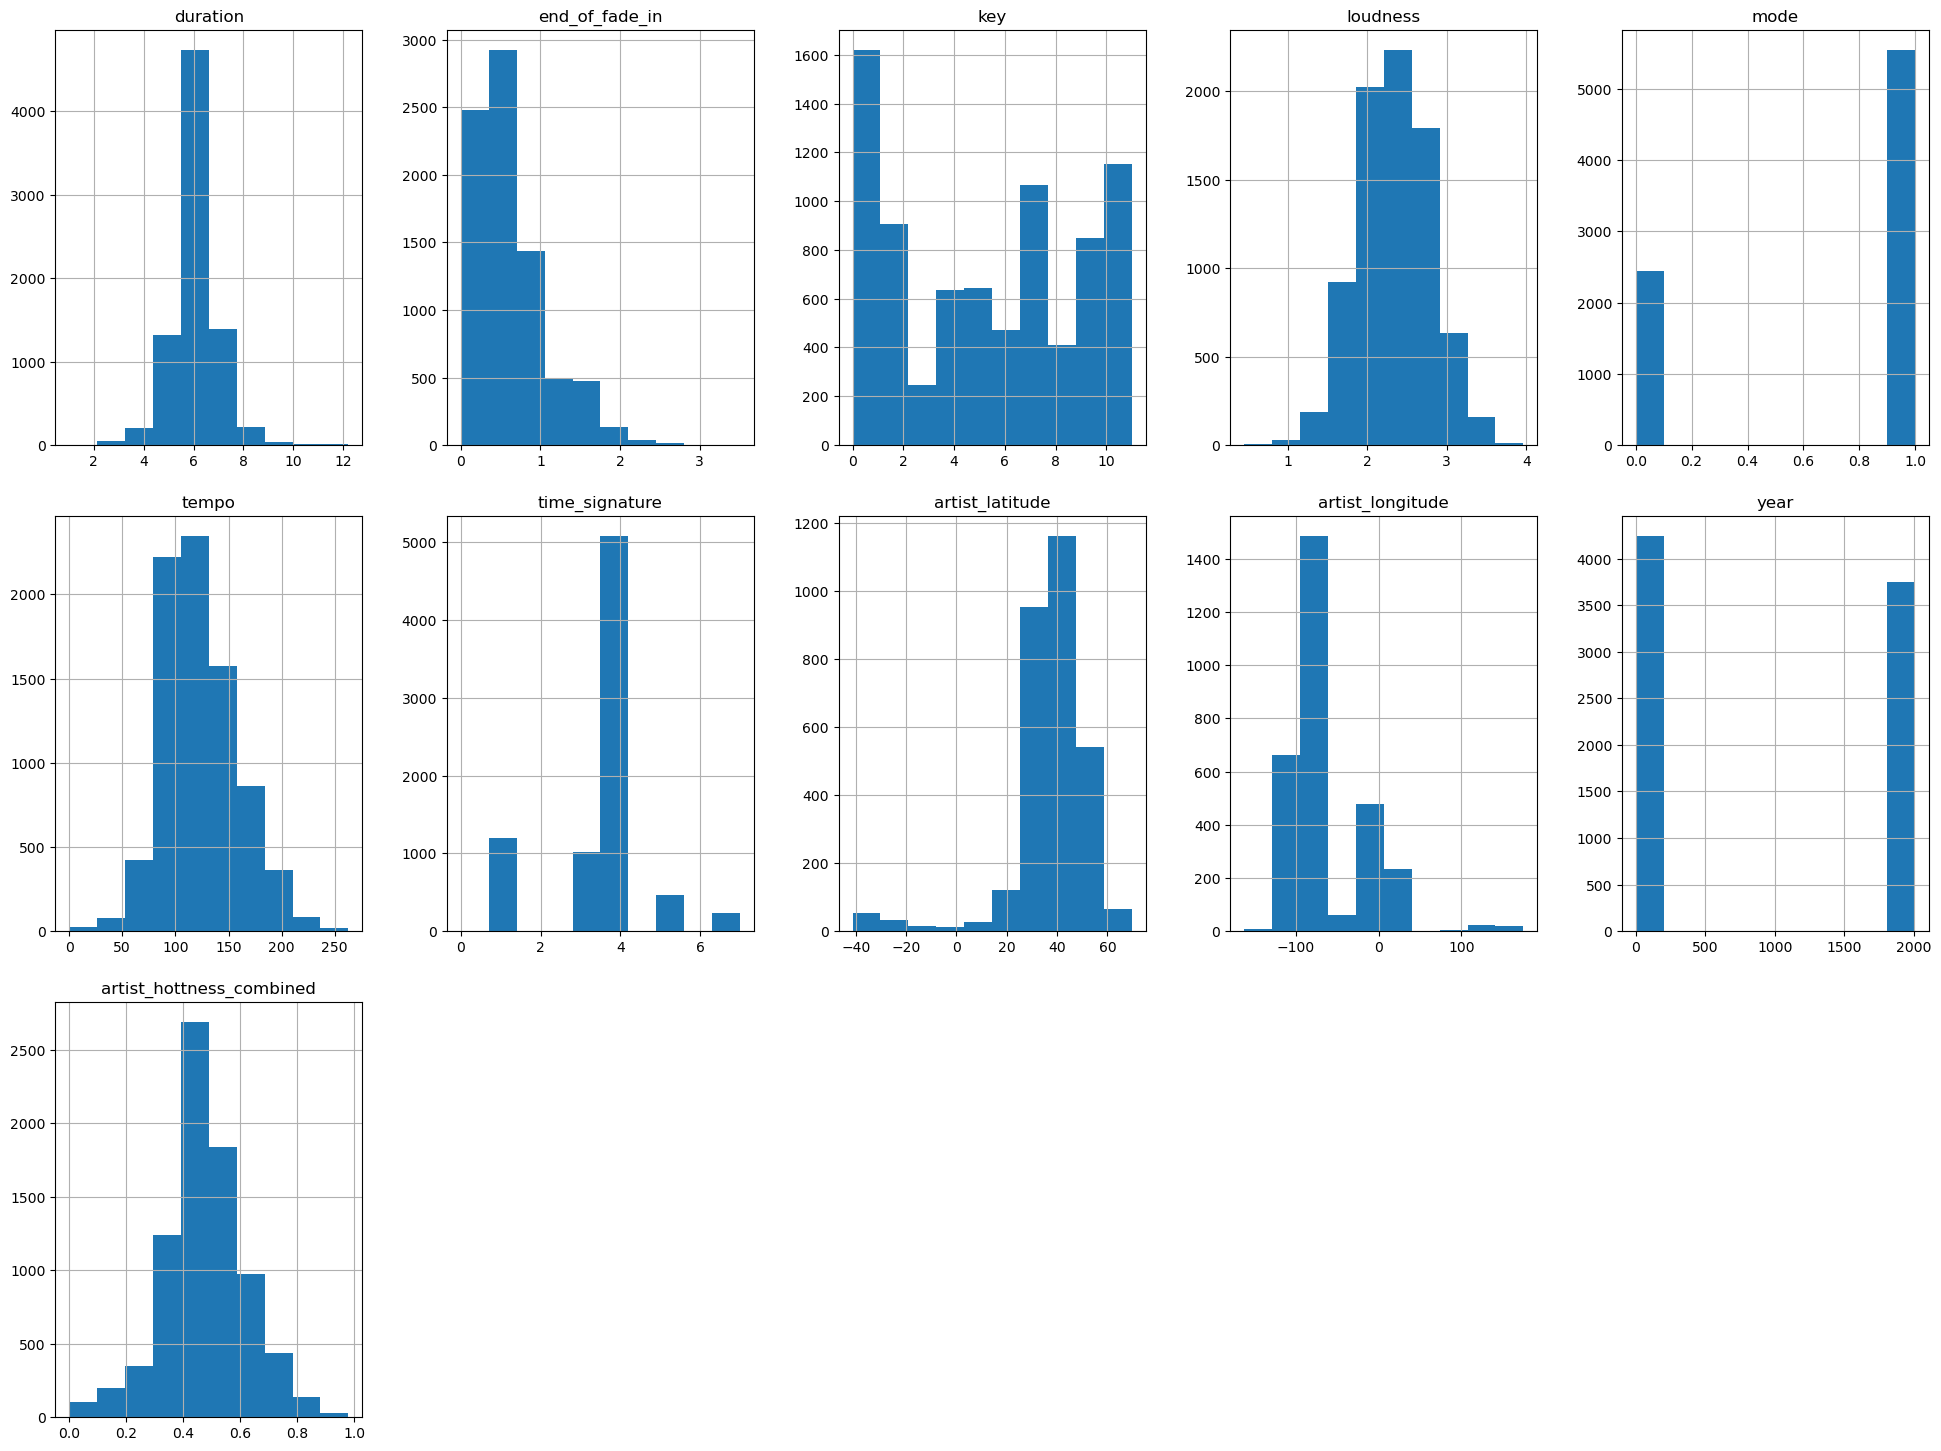

In [17]:
fig, axes = plt.subplots(3,5, figsize=(20,15))
fig.tight_layout(pad=3.0)
axes = axes.flatten()

for i, name in enumerate(column_names_numeric):
    train[name].hist(ax = axes[i])
    axes[i].set_title(name)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

The transformed features exhibit distributions that are closer to normal

Given the nature of musical features, we created interaction terms to capture potentially meaningful relationships:
- $\text{key} \times \text{mode}$
- $\text{tempo} \times \text{time signature}$

Additionally, we constructed a bag-of-words matrix, where each column represents one of the most frequent words extracted from each song's combined with its artist's top 10 bags

<a id="section3"></a>

# Data Preparation

<a id="section5"></a>

## Na Value

We checked the columns containing missing(NA) values

In [18]:
na_idx = train.isna().sum().index[np.where(train.isna().sum() != 0)]
train.isna().sum()[na_idx].rename("number of NA value")

artist_latitude             5018
artist_longitude            5018
song_hotttnesss             3470
tag_top_1                      5
tag_top_2                    107
tag_top_3                    161
tag_top_4                    225
tag_top_5                    291
tag_top_6                    350
tag_top_7                    435
tag_top_8                    476
tag_top_9                    533
tag_top_10                   582
artist_hottness_combined       2
Name: number of NA value, dtype: int64

We did not impute the missing values for 'artist_latitude', 'artist_longitude' and 'song_hottnesss' using common strategies because they account for a large proportion of the data, which would likely distort the information and negatively impact model performance. Therefore, we dropped these columns

In [19]:
print("artist latitude na proportion:",5018 * 100/8000,"%")
print("artist longitude na proportion:", 3470 * 100/8000,"%")

artist latitude na proportion: 62.725 %
artist longitude na proportion: 43.375 %


In [20]:
train = train.drop(train[train['artist_latitude'].isna()].index)
train = train.drop(train[train['song_hotttnesss'].isna()].index)

We observed that a large proportion of songs have an unkonwn published year. According to the [feature description](http://millionsongdataset.com/pages/example-track-description/) of 'year', the published year of each songin the dataset is collected from MusicBrainz, where all information is contributed by community volunteers. Therefore, we interpret a year value of 0 as having certain implications - for example, some songs may not have been officially published and were only distributed within a small region. The difference between 0 and other year values could still capture a potential year-related effect on song hottness, even though it is not precisely measured. Based on this reasoning, we kept the rows where 'year' equals 0 

In [21]:
print("Number of songs that have published year 0:", sum(train['year'] == 0)) 
print("proportion:",sum(train['year'] == 0) * 100/train.shape[0])

Number of songs that have published year 0: 795
proportion: 45.11918274687855


Three additional features that are irrelevant to our model fitting will be dropped

In [22]:
train = train.drop(columns = ['genre','artist_name', 'artist_location','release'])

<a id="section6"></a>

## Bag-of-words Matrix

In [23]:
title_tag_string = train.columns.values[-13:-2]
title_tag_string

array(['title', 'tag_top_1', 'tag_top_2', 'tag_top_3', 'tag_top_4',
       'tag_top_5', 'tag_top_6', 'tag_top_7', 'tag_top_8', 'tag_top_9',
       'tag_top_10'], dtype=object)

We wrote reuseable functions to create the bag-of-words matrix

Function for combining each song's title with the top 10 tags of the artist who created it 

In [24]:
def combine_tags_title(df, title_tag_string):
    combine_series = df[title_tag_string[0]].fillna('').astype(str)
    for i in range(1, len(title_tag_string)):
        combine_series = combine_series + ' ' + df[title_tag_string[i]].fillna('').astype(str)

    return combine_series

In [25]:
sample_text = combine_tags_title(train, title_tag_string).head()
sample_text

1561    b'Bahama Lullaby' country blues piedmont blues...
5933    b"In Fate's Hands (Album Version)" screamo roc...
168     b'Robbers Kill Cop' electronica rock ambient a...
2588    b'Pickled Heads' instrumental rock flamenco ta...
6874    b'A Martyr For My Love For You' blues-rock gar...
dtype: object

We noticeed that the combined text data was not sufficiently clean, so additional cleaning was needed. We also implemented a function for text cleaning.

In [26]:
def string_cleaning(combined_text):
    combined_text = [text.lower() for text in combined_text]
    combined_text = [text[1:] for text in combined_text]
    combined_text = [re.sub(r"[^a-zA-Z\s]", "", text) for text in combined_text]

    return combined_text

In [27]:
string_cleaning(sample_text)

['bahama lullaby country blues piedmont blues delta blues ragtime chicago blues louisiana blues blues smooth jazz piano blues country rock',
 'in fates hands album version screamo rock alternative alternative rock emo pop acoustic metal pop emotional original',
 'robbers kill cop electronica rock ambient alternative club progressive house soundtrack techno electronic rap',
 'pickled heads instrumental rock flamenco tango soundtrack neoclassical sympho black metal rb opera downtempo goa',
 'a martyr for my love for you bluesrock garage rock blues alternative rock indie rock rock detroit indie alternative pop']

Now that the combined text is clean, we can proceed to build a pipeline for creating the bag-of-words matrix. Before that, we need to implement some custom transformers

In [28]:
class TextCleaningTransformer(BaseEstimator, TransformerMixin): # cleaning texts
    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y = None):
        #column_names = X.columns.values
        column_names_text = X.columns.values[-13:-2]

        text_combined = combine_tags_title(X,column_names_text)
        text_combined = string_cleaning(text_combined)

        return text_combined

In [29]:
class Text_Token_transformer_df(BaseEstimator, TransformerMixin): # create bag-of-words matrix
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        vectorizer = CountVectorizer()
        X_matrix = vectorizer.fit_transform(X).toarray()

        X_df = pd.DataFrame(X_matrix)

        for word, index in vectorizer.vocabulary_.items():
            X_df = X_df.rename(columns={index: word})
        
        column_sum_X = X_df.sum(axis=0).values
        sorted_index_X = np.argsort(-column_sum_X)
        X_df = X_df.iloc[:,sorted_index_X]

        index_less_then_2 = np.where(X_df.sum(axis=0).values <3)[0][0]
        X_df = X_df.iloc[:,:index_less_then_2]
        
        return X_df
        

After all the relevant custom transformers were created, we built the pipeline for generating the bag-of-words matrix

In [30]:
Pipe_word_matrix_df = Pipeline([
    ('clean_text',TextCleaningTransformer()),
    ('text_token_to_df', Text_Token_transformer_df())
])

In [31]:
word_matrix = Pipe_word_matrix_df.fit_transform(train)

In [32]:
word_matrix.head()

,rock,pop,jazz,blues,metal,country,alternative,rap,soul,hop,...,que,al,ya,had,him,without,wo,simplicity,since,should
0,1,0,1,7,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="section7"></a>

## Encoding Categorical Variable

For categorical variable encoding, we applied one-hot encoding to all categorical variables except for the interaction term $\text{tempo} \times \text{time signature}$. We first worte functions to perform this task, then implemented custom transformers to combine all columns from the one-hot encoded matrices and the bag-of-words matrix. Finally, we automated these operations by creating a pipeline.

In [34]:
def key_mode_interaction_encode(X): # 1. key one-h array 2.mode one-h array #3 key-mode interaction df
    key_encoder = OneHotEncoder()
    mode_encoder = OneHotEncoder()

    key_onehot = key_encoder.fit_transform(X[['key']])  
    mode_onehot = mode_encoder.fit_transform(X[['mode']]) 

    key_mode_interaction_matrix = np.einsum('ij,ik->ijk', key_onehot.toarray(), mode_onehot.toarray()).reshape(key_onehot.shape[0], -1)

    key_labels = key_encoder.categories_[0]
    mode_labels = mode_encoder.categories_[0]
    interaction_columns = [f'key_{k}_x_mode_{m}' for k in key_labels for m in mode_labels]
        
    return (key_onehot.toarray() , mode_onehot.toarray() , 
            pd.DataFrame(key_mode_interaction_matrix, columns=interaction_columns))

In [35]:
key_mode_interaction_encode(train)[0].shape

(1762, 12)

In [36]:
def timsig_tempo_interaction_encode(X):# 1. time signature one-h array #2. time-tempo interaction df
    timesig_encoder = OneHotEncoder()
    timesig_onehot = timesig_encoder.fit_transform(X[['time_signature']])
    
    tempo_timesig_interaction_matrix = X['tempo'].values.reshape(-1,1) * timesig_onehot.toarray()

    return timesig_onehot.toarray(), pd.DataFrame(tempo_timesig_interaction_matrix,
    columns=[f'tempo_x_timesig_{cat}' for cat in timesig_encoder.categories_[0]])

In [37]:
class combine_cat_columns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        key_cat_matrix = key_mode_interaction_encode(X)[0]
        mode_cat_matrix = key_mode_interaction_encode(X)[1]
        kry_mode_cat_interaction_matrix = key_mode_interaction_encode(X)[2].to_numpy()

        timesig_cat_matrix = timsig_tempo_interaction_encode(X)[0]
        #timesig_tempo_cat_interaction_matrix = timsig_tempo_interaction_encode(X)[1].to_numpy()

        return np.concat([key_cat_matrix, mode_cat_matrix, kry_mode_cat_interaction_matrix, timesig_cat_matrix],
                         axis = 1)


class combine_cat_word_columns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #word_matrix = word_matrix  #Pipe_word_matrix_df.fit_transform(train).to_numpy() 

        return np.concat([word_matrix, X], axis=1)

In [38]:
Pipe_cat = Pipeline([
    ('cat_columns', combine_cat_columns()),
    ('combine_word_cat_matrix', combine_cat_word_columns())
])

In [39]:
cat_columns = Pipe_cat.fit_transform(train)

In [40]:
print(cat_columns.shape)
cat_columns[:5, ]

(1762, 829)


array([[1., 0., 1., ..., 0., 0., 0.],
       [2., 2., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [4., 1., 0., ..., 1., 0., 0.]])

<a id="section8"></a>

## Scaling

Then we standardized the numerical variables

In [41]:
train_numeric = train[['duration', 'end_of_fade_in','loudness','tempo','artist_latitude', 
                         'artist_longitude','year','artist_hottness_combined']]
train_numeric = np.concatenate([train_numeric.to_numpy(), timsig_tempo_interaction_encode(train)[1]], axis=1)

scaler = StandardScaler()
train_numeric = scaler.fit_transform(train_numeric)

We combined all columns except the target variable to obtain the final processed design matrix

In [42]:
matrix_list = [cat_columns, train_numeric]
def combine_all_columns(lst):
    return np.concatenate(lst, axis=1)

X_train = combine_all_columns(matrix_list)
y = train['song_hotttnesss']

In [43]:
X_train.shape

(1762, 842)

<a id="section4"></a>

# Feature selection

Before fitting different ML models, we noticed that the ratio of instances to features was not large, which could easily lead to model overfitting. Therefore, we first conducted feature selection to remove potentially sparse features

In [44]:
X_train.shape[0] / X_train.shape[1]

2.0926365795724466

To achieve this, we applied LASSO and forward stepwise regression

<a id="section9"></a>

## LASSO

We defined the alpha parameter space from $10^{-4}$ to $10$ and selected 50 values evenly spaced on a logarithmic scale. We then searched for the optimal alpha value through cross-validation

In [45]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5) #start: 10^-4 end: 10^1
lasso_cv.fit(X_train, y)

LassoCV(alphas=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38949549e-0...
       2.81176870e-02, 3.55648031e-02, 4.49843267e-02, 5.68986603e-02,
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
        cv=5)

In [46]:
lasso_cv.alpha_ # best alpha

np.float64(0.0010481131341546852)

In [47]:
lasso_reg = Lasso(alpha= lasso_cv.alpha_ )
lasso_reg.fit(X_train, y)

model = SelectFromModel(lasso_reg, prefit=True)
X_train_selected_lasso = model.transform(X_train)

The LASSO-selected features were reduced to 75

In [48]:
X_train_selected_lasso.shape

(1762, 75)

<a id="section10"></a>

## Forward Step-Wise

By conducting forward step-wise regression, we selected 235 features, which is slightly more than those selected using LASSO regression

In [49]:
sfs_reg = SequentialFeatureSelector(LinearRegression(), k_features=(1, 400) ,forward=True, scoring='neg_mean_squared_error',n_jobs=20, verbose=0)
sfs_reg = sfs_reg.fit(X_train, y)

In [50]:
len(sfs_reg.k_feature_names_)

235

In [51]:
subset_info = sfs_reg.subsets_

feature_num_lis = []
cv_error_lis = []
training_error_lis = []

for i in range(400):
    cv_error_lis.append(abs(subset_info[i+1]["avg_score"]))
    feature_num_lis.append(i+1)

    X_train_progress = X_train[:,subset_info[i+1]["feature_idx"]]
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_progress, y)
    y_pred = lin_reg.predict(X_train_progress)
    training_error_lis.append(mean_squared_error(y, y_pred))

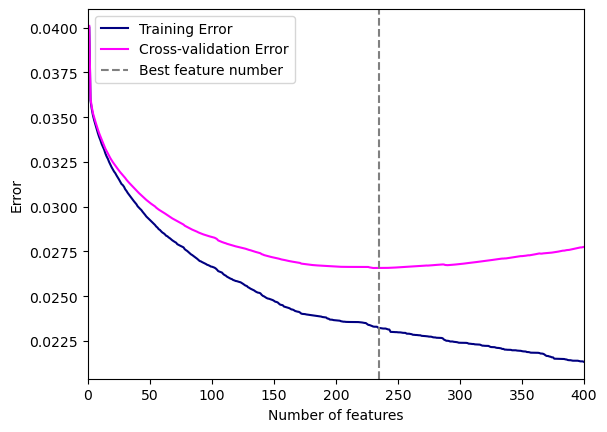

In [52]:
fig,ax = plt.subplots()
ax.plot(feature_num_lis, training_error_lis, label= "Training Error", color = "navy")
ax.plot(feature_num_lis, cv_error_lis, label = "Cross-validation Error", color = "magenta")
ax.set(xlim=(0,400))
ax.set_ylabel("Error")
ax.set_xlabel("Number of features")
ax.axvline(x=len(sfs_reg.k_feature_names_), color='grey', linestyle='--', label='Best feature number')
ax.legend()
plt.show()

In [53]:
X_train_selected_stepwise = X_train[:, sfs_reg.k_feature_idx_]
X_train_selected_stepwise.shape

(1762, 235)

After all the preparation work was completed, we started fitting all the candidates models

<a id="section11"></a>

# Model Fitting

We perfromed both regression tasks using the original "song_hottness" as the target variable, as well as a classification task by setting a threshold to assign the "hot" label to songs above it. For both tasks, We selected a set of candidate models and trained each model using the two different selected design matrices to explore which one would yield better results.

<a id="section12"></a>

## Fitting with LASSO selected design matrix 

### Regression

Function for perfroming multiple rounds of 5-fold cross-validation with the negative mean squared error score

In [54]:
def multi_time_cv_mse(times, reg, design_matrix):
    cv_sore_calculated = []
    for i in range(times):
        cv_sore_calculated.append(cross_val_score(reg, design_matrix, y, cv=5, scoring="neg_mean_squared_error").mean())
    
    return np.abs(np.array(cv_sore_calculated).mean())

#### Linear regressor

In [55]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_selected_lasso, y)
print("SGD regression CV MSE:",
      multi_time_cv_mse(10, sgd_reg, X_train_selected_lasso),
      "\nSGD regression R^2:", r2_score(y, sgd_reg.predict(X_train_selected_lasso))
      )

SGD regression CV MSE: 0.034912523963368795 
SGD regression R^2: 0.41839371825203686


#### Kernel SVM regressor

In [56]:
rbf_svc_reg = SVR(kernel="rbf", C=0.1, gamma=1e-3)
rbf_svc_reg.fit(X_train_selected_lasso, y)
print("RBF SVM regression CV MSE:",
      multi_time_cv_mse(10, rbf_svc_reg, X_train_selected_lasso),
      "\nRBF SVM regression R^2:", r2_score(y, rbf_svc_reg.predict(X_train_selected_lasso))
      )

RBF SVM regression CV MSE: 0.037006544069902045 
RBF SVM regression R^2: 0.3708443232742672


#### Random Froest regressor

In [57]:
rfg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rfg.fit(X_train_selected_lasso, y)

print("Random froest regression CV MSE:",
      multi_time_cv_mse(10, rfg, X_train_selected_lasso),
      "\nRandom froest regression R^2:", r2_score(y, rfg.predict(X_train_selected_lasso))
      )

Random froest regression CV MSE: 0.03310194378897624 
Random froest regression R^2: 0.9208916953245135


#### XG Boost regressor

In [58]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8)
xgb_reg.fit(X_train_selected_lasso, y)

print("XG Boost regression CV MSE:",
      multi_time_cv_mse(10, xgb_reg, X_train_selected_lasso),
      "\nXG Boost regression R^2:", r2_score(y, xgb_reg.predict(X_train_selected_lasso))
      )

XG Boost regression CV MSE: 0.03331098649315502 
XG Boost regression R^2: 0.8568202082938023


#### Light GBM regressor

In [59]:
lgb_reg = LGBMRegressor(verbose=-1)
lgb_reg.fit(X_train_selected_lasso, y)

print("Light GBM regression CV MSE:",
      multi_time_cv_mse(10, lgb_reg, X_train_selected_lasso),
      "\nLight GBM regression R^2:", r2_score(y, lgb_reg.predict(X_train_selected_lasso))
      )

  File "d:\miniconda3\envs\pydata-book\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\miniconda3\envs\pydata-book\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\miniconda3\envs\pydata-book\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\miniconda3\envs\pydata-book\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Light GBM regression CV MSE: 0.035004056341836336 
Light GBM regression R^2: 0.8643248061373123


### Classification

We set the label threshold to 0.6, considerig it an appropriate proportion for hot songs

In [60]:
print(np.round((y >= 0.6).sum() / len(y),2))

0.14


In [61]:
y_label = y.copy()
y_label[y.iloc[np.where(y>= 0.6)].index] = 1
y_label[y.iloc[np.where(y< 0.6)].index] = 0

Function for perfroming multiple rounds of 5-fold cross-validation with a specified performance metric

In [62]:
def multi_time_cv_scroe(times, clf, design_matrix, score_type):
    score_type = str(score_type)
    cv_sore_calculated = []
    for i in range(times):
        cv_sore_calculated.append(cross_val_score(clf, design_matrix, y_label, cv=5, scoring=score_type).mean())
    
    return np.array(cv_sore_calculated).mean()

#### Logistic classifier

In [63]:
sgd_classifer = SGDClassifier()

print('Logistic classifier cv accuracy:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_lasso, "accuracy"))
print('Logistic classifier cv precision:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_lasso, "precision"))
print('Logistic classifier cv recall:', multi_time_cv_scroe(10, sgd_classifer, X_train_selected_lasso, "recall"))
print('Logistic classifier cv F1 score:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_lasso, "f1"))
print('Logistic classifier cv AUC:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_lasso, "roc_auc"))

Logistic classifier cv accuracy: 0.851407899819727
Logistic classifier cv precision: 0.4775100613725697
Logistic classifier cv recall: 0.4078509803921569
Logistic classifier cv F1 score: 0.4071406892444148
Logistic classifier cv AUC: 0.790898173383014


#### RBF SVM classifier

In [64]:
rbf_svc_clf = SVC(kernel='rbf', gamma = 0.1, C= 10)
print('RBF SVM classifier cv accuracy:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_lasso, "accuracy"))
print('RBF SVM classifier cv precision:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_lasso, "precision"))
print('RBF SVM classifier cv recall:', multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_lasso, "recall"))
print('RBF SVM classifier cv F1 score:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_lasso, "f1"))
print('RBF SVM classifier cv AUC:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_lasso, "roc_auc"))

RBF SVM classifier cv accuracy: 0.8575424929178471
RBF SVM classifier cv precision: 0.5160154660154659
RBF SVM classifier cv recall: 0.3163137254901961
RBF SVM classifier cv F1 score: 0.3900910053868546
RBF SVM classifier cv AUC: 0.7813129554301315


#### Random Froest classifier

In [65]:
rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')

print('Random Forest classifier cv accuracy:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_lasso, "accuracy"))
print('Random Forest classifier cv precision:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_lasso, "precision"))
print('Random Forest classifier cv recall:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_lasso, "recall"))
print('Random Forest classifier cv F1 score:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_lasso, "f1"))
print('Random Forest classifier cv AUC:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_lasso, "roc_auc"))

Random Forest classifier cv accuracy: 0.8780887844450167
Random Forest classifier cv precision: 0.6888672212409692
Random Forest classifier cv recall: 0.3100627450980392
Random Forest classifier cv F1 score: 0.4195410401035563
Random Forest classifier cv AUC: 0.846360724218842


#### XG Boost classifier

In [66]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=None, subsample=0.8)

print('XG Boost classifier cv accuracy:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_lasso, "accuracy"))
print('XG Boost classifier cv precision:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_lasso, "precision"))
print('XG Boost classifier cv recall:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_lasso, "recall"))
print('XG Boost classifier cv F1 score:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_lasso, "f1"))
print('XG Boost classifier cv AUC:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_lasso, "roc_auc"))

XG Boost classifier cv accuracy: 0.8774014936904454
XG Boost classifier cv precision: 0.630136655680948
XG Boost classifier cv recall: 0.3832941176470589
XG Boost classifier cv F1 score: 0.47399512047848696
XG Boost classifier cv AUC: 0.8493536387602939


#### Naive Bayes classifier

In [67]:
gnb_clf = GaussianNB()

print('Naive Bayes classifier cv accuracy:', multi_time_cv_scroe(10, gnb_clf, X_train_selected_lasso, "accuracy"))
print('Naive Bayes classifier cv precision:', multi_time_cv_scroe(10, gnb_clf, X_train_selected_lasso, "precision"))
print('Naive Bayes classifier cv recall:', multi_time_cv_scroe(10, gnb_clf, X_train_selected_lasso, "recall"))
print('Naive Bayes classifier cv F1 score:',multi_time_cv_scroe(10, gnb_clf, X_train_selected_lasso, "f1"))
print('Naive Bayes classifier cv AUC:',multi_time_cv_scroe(10, gnb_clf, X_train_selected_lasso, "roc_auc"))

Naive Bayes classifier cv accuracy: 0.5425122328096832
Naive Bayes classifier cv precision: 0.21946259739741478
Naive Bayes classifier cv recall: 0.8458823529411765
Naive Bayes classifier cv F1 score: 0.34818802096378026
Naive Bayes classifier cv AUC: 0.7510890922825315


#### Light GBM classifier

In [68]:
lgb_clf = LGBMClassifier(verbose = -1)

print('Light GBM classifier cv accuracy:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_lasso, "accuracy"))
print('Light GBM classifier cv precision:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_lasso, "precision"))
print('Light GBM classifier cv recall:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_lasso, "recall"))
print('Light GBM classifier cv F1 score:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_lasso, "f1"))
print('Light GBM classifier cv AUC:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_lasso, "roc_auc"))

Light GBM classifier cv accuracy: 0.8807993175379861
Light GBM classifier cv precision: 0.6497344088136927
Light GBM classifier cv recall: 0.3949019607843137


Light GBM classifier cv F1 score: 0.48718100835747896
Light GBM classifier cv AUC: 0.8479984055226897


<a id="section13"></a>

## Fitting with foward-stepwise matrix

All the following code is the same as before, but uses the forward stepwise regression-selected matrix instead 

### Regression

#### Linear regressor

In [69]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_selected_stepwise, y)
print("SGD regression CV MSE:",
      multi_time_cv_mse(10, sgd_reg, X_train_selected_stepwise),
      "\nSGD regression R^2:", r2_score(y, sgd_reg.predict(X_train_selected_stepwise))
      )

SGD regression CV MSE: 0.03350066593013142 
SGD regression R^2: 0.43675001153438586


#### RBF SVM regressor

In [70]:
rbf_svc_reg = SVR(kernel="rbf", C=0.1, gamma=1e-3)
rbf_svc_reg.fit(X_train_selected_stepwise, y)
print("RBF SVM regression CV MSE:",
      multi_time_cv_mse(10, rbf_svc_reg, X_train_selected_stepwise),
      "\nRBF SVM regression R^2:", r2_score(y, rbf_svc_reg.predict(X_train_selected_stepwise))
      )

RBF SVM regression CV MSE: 0.03704638768724049 
RBF SVM regression R^2: 0.3661081898474353


#### Random Forest regressor

In [71]:
rfg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rfg.fit(X_train_selected_stepwise, y)

print("Random froest regression CV MSE:",
      multi_time_cv_mse(10, rfg, X_train_selected_stepwise),
      "\nRandom froest regression R^2:", r2_score(y, rfg.predict(X_train_selected_stepwise))
      )

Random froest regression CV MSE: 0.032614270320121486 
Random froest regression R^2: 0.9200426715146576


#### XG Boost regressor

In [72]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8)
xgb_reg.fit(X_train_selected_stepwise, y)

print("XG Boost regression CV MSE:",
      multi_time_cv_mse(10, xgb_reg, X_train_selected_stepwise),
      "\nXG Boost regression R^2:", r2_score(y, xgb_reg.predict(X_train_selected_stepwise))
      )

XG Boost regression CV MSE: 0.03208947271528085 
XG Boost regression R^2: 0.7890766635587116


#### LightGBM regressor

In [73]:
lgb_reg = LGBMRegressor(verbose=-1)
lgb_reg.fit(X_train_selected_stepwise, y)

print("Light GBM regression CV MSE:",
      multi_time_cv_mse(10, lgb_reg, X_train_selected_stepwise),
      "\nLight GBM regression R^2:", r2_score(y, lgb_reg.predict(X_train_selected_stepwise))
      )

Light GBM regression CV MSE: 0.034397266411235854 
Light GBM regression R^2: 0.8167117753353552


### Classification

#### Logistic classifier

In [74]:
sgd_classifer = SGDClassifier()

print('Logistic classifier cv accuracy:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_stepwise, "accuracy"))
print('Logistic classifier cv precision:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_stepwise, "precision"))
print('Logistic classifier cv recall:', multi_time_cv_scroe(10, sgd_classifer, X_train_selected_stepwise, "recall"))
print('Logistic classifier cv F1 score:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_stepwise, "f1"))
print('Logistic classifier cv AUC:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_stepwise, "roc_auc"))

Logistic classifier cv accuracy: 0.8618516610867886
Logistic classifier cv precision: 0.518776512002671
Logistic classifier cv recall: 0.4738666666666666
Logistic classifier cv F1 score: 0.48039551253097157
Logistic classifier cv AUC: 0.8193587537710293


#### RBF SVM classifier

In [75]:
rbf_svc_clf = SVC(kernel='rbf', gamma = 0.1, C= 10)

print('RBF SVM classifier cv accuracy:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_stepwise, "accuracy"))
print('RBF SVM classifier cv precision:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_stepwise, "precision"))
print('RBF SVM classifier cv recall:', multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_stepwise, "recall"))
print('RBF SVM classifier cv F1 score:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_stepwise, "f1"))
print('RBF SVM classifier cv AUC:',multi_time_cv_scroe(10, rbf_svc_clf, X_train_selected_stepwise, "roc_auc"))

RBF SVM classifier cv accuracy: 0.8564077388617047
RBF SVM classifier cv precision: 0.49921071890112145
RBF SVM classifier cv recall: 0.38721568627450986
RBF SVM classifier cv F1 score: 0.43504454729013553
RBF SVM classifier cv AUC: 0.8006577866014727


#### Random Froest classifier

In [76]:
rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')

print('Random Forest classifier cv accuracy:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_stepwise, "accuracy"))
print('Random Forest classifier cv precision:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_stepwise, "precision"))
print('Random Forest classifier cv recall:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_stepwise, "recall"))
print('Random Forest classifier cv F1 score:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_stepwise, "f1"))
print('Random Forest classifier cv AUC:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_stepwise, "roc_auc"))

Random Forest classifier cv accuracy: 0.8825713044038114
Random Forest classifier cv precision: 0.7035481103422839
Random Forest classifier cv recall: 0.3150196078431372
Random Forest classifier cv F1 score: 0.4424674835442756
Random Forest classifier cv AUC: 0.8363362903639817


#### XG Boost classifier

In [77]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=None, subsample=0.8)

print('XG Boost classifier cv accuracy:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_stepwise, "accuracy"))
print('XG Boost classifier cv precision:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_stepwise, "precision"))
print('XG Boost classifier cv recall:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_stepwise, "recall"))
print('XG Boost classifier cv F1 score:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_stepwise, "f1"))
print('XG Boost classifier cv AUC:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_stepwise, "roc_auc"))

XG Boost classifier cv accuracy: 0.8802424027813546
XG Boost classifier cv precision: 0.6318988793988793
XG Boost classifier cv recall: 0.4069019607843137
XG Boost classifier cv F1 score: 0.4936255587223612
XG Boost classifier cv AUC: 0.863598342709947


#### Naive Bayes classifier

In [78]:
gnb_clf = GaussianNB()

print('Naive Bayes classifier cv accuracy:', multi_time_cv_scroe(10, gnb_clf, X_train_selected_stepwise, "accuracy"))
print('Naive Bayes classifier cv precision:', multi_time_cv_scroe(10, gnb_clf, X_train_selected_stepwise, "precision"))
print('Naive Bayes classifier cv recall:', multi_time_cv_scroe(10, gnb_clf, X_train_selected_stepwise, "recall"))
print('Naive Bayes classifier cv F1 score:',multi_time_cv_scroe(10, gnb_clf, X_train_selected_stepwise, "f1"))
print('Naive Bayes classifier cv AUC:',multi_time_cv_scroe(10, gnb_clf, X_train_selected_stepwise, "roc_auc"))

Naive Bayes classifier cv accuracy: 0.3847942956476951
Naive Bayes classifier cv precision: 0.16665565306049707
Naive Bayes classifier cv recall: 0.8179607843137255
Naive Bayes classifier cv F1 score: 0.2768008996152721
Naive Bayes classifier cv AUC: 0.5646256804893526


#### Light GBM classifier

In [79]:
lgb_clf = LGBMClassifier(verbose = -1)

print('Light GBM classifier cv accuracy:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_stepwise, "accuracy"))
print('Light GBM classifier cv precision:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_stepwise, "precision"))
print('Light GBM classifier cv recall:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_stepwise, "recall"))
print('Light GBM classifier cv F1 score:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_stepwise, "f1"))
print('Light GBM classifier cv AUC:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_stepwise, "roc_auc"))

Light GBM classifier cv accuracy: 0.880244012361576
Light GBM classifier cv precision: 0.6262383772271571
Light GBM classifier cv recall: 0.4385098039215687
Light GBM classifier cv F1 score: 0.5114430605519873
Light GBM classifier cv AUC: 0.864146791135983


<a id="section14"></a>

## Summarizing table

Finally, we created a table summarizing the evaluations of all models

<table>
  <tr>
    <th>Design matrix</th>
    <th>Models</th>
    <th>cv MSE</th>
    <th>R<sup>2</sup></th>
  </tr>
  <tr>
    <td rowspan="5">LASSO regression selected design matrix</td>
    <td>Linear regression</td>
    <td>0.0349</td>
    <td>0.418</td>
  </tr>
  <tr>
    <td>RBF Kernel SVM</td>
    <td>0.0370</td>
    <td>0.371</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.0331</td>
    <td>0.921</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.0333</td>
    <td>0.857</td>
  </tr>
  <tr>
    <td>Light GBM</td>
    <td>0.0350</td>
    <td>0.864</td>
  </tr>


  <tr>
    <td rowspan="5">Forward-stepwise regression selected design matrix</td>
    <td>Linear regression</td>
    <td>0.0335</td>
    <td>0.437</td>
  </tr>
  <tr>
    <td>RBF Kernel SVM</td>
    <td>0.0370</td>
    <td>0.366</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.0326</td>
    <td>0.920</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.0321</td>
    <td>0.789</td>
  </tr>
  <tr>
    <td>Light GBM</td>
    <td>0.0344</td>
    <td>0.817</td>
  </tr>
</table>

<table>
  <tr>
    <th>Design matrix</th>
    <th>Models</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1 Score</th>
    <th>AUC</th>
  </tr>
  <tr>
    <td rowspan="6">LASSO regression selected design matrix</td>
    <td>Logistic regression</td>
    <td>0.851</td>
    <td>0.478</td>
    <td>0.408</td>
    <td>0.407</td>
    <td>0.791</td>
  </tr>
  <tr>
    <td>RBF Kernel SVM</td>
    <td>0.858</td>
    <td>0.516</td>
    <td>0.316</td>
    <td>0.390</td>
    <td>0.781</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.878</td>
    <td>0.689</td>
    <td>0.310</td>
    <td>0.420</td>
    <td>0.846</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.877</td>
    <td>0.630</td>
    <td>0.383</td>
    <td>0.474</td>
    <td>0.849</td>
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>0.543</td>
    <td>0.219</td>
    <td>0.846</td>
    <td>0.348</td>
    <td>0.751</td>
  </tr>
  <tr>
   <td>Light GBM</td>
   <td>0.881</td>
   <td>0.650</td>
   <td>0.395</td>
   <td>0.487</td>
   <td>0.848</td>
  </tr>


  <tr>
    <td rowspan="6">Forward-stepwise regression selected design matrix</td>
    <td>Logistic regression</td>
    <td>0.862</td>
    <td>0.519</td>
    <td>0.474</td>
    <td>0.480</td>
    <td>0.819</td>
  </tr>
  <tr>
    <td>RBF Kernel SVM</td>
    <td>0.856</td>
    <td>0.499</td>
    <td>0.387</td>
    <td>0.435</td>
    <td>0.801</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.883</td>
    <td>0.704</td>
    <td>0.315</td>
    <td>0.442</td>
    <td>0.836</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.880</td>
    <td>0.632</td>
    <td>0.407</td>
    <td>0.494</td>
    <td>0.864</td>
  </tr>
  <tr>
   <td>Naive Bayes</td>
   <td>0.385</td>
   <td>0.167</td>
   <td>0.818</td>
   <td>0.277</td>
   <td>0.565</td>
  </tr>
  <tr>
    <td>Light GBM</td>
    <td>0.880</td>
    <td>0.626</td>
    <td>0.439</td>
    <td>0.511</td>
    <td>0.864</td>
  </tr>
</table>

We set the linear models as the benchmark for both tasks.

For the regression task trained on the LASSO-selected design matrix, the RBF-kernel SVM showed the poorest performance, with the highest MSE of 0.0370 and an $R^2$ of 0.371. Random Forest performed the best, achieving the lowest MSE of 0.0331 and the highest $R^2$ of 0.921. XGBoost performed comparably to Random Forest, with a slightly higher MSE, although the difference in $R^2$ between the two was relatively significant. LightGBM performed at a similar level to linear regression but significantly improved the $R^2$. After switching to the forward-stepwise–selected design matrix, the MSE of all models except SVM decreased. However, this came at the cost of reduced $R^2$ for the three ensemble learning algorithms.

For the classification task trained on the LASSO-selected design matrix, the three ensemble learning algorithms outperformed logistic regression and the RBF-kernel SVM across all metrics except recall. LightGBM achieved the highest accuracy (0.881) and F1-score (0.487), Random Forest achieved the highest precision (0.689), and XGBoost achieved the highest AUC (0.849). Most models performed poorly in terms of recall, with values between 0.31 and 0.41, but Naive Bayes was a notable exception, which achieved a recall of 0.846 and was substantially higher than that of the other models. After switching to the forward-stepwise–selected design matrix, the performance of the three ensemble learning algorithms and logistic regression generally improved. However, some metrics declined for certain models — for example, LightGBM’s precision and accuracy both decreased. Naive Bayes, on the other hand, did not benefit from the new matrix, as all of its metrics dropped.

We have explored the performance of different models across both tasks so far. Our results show that popular ensemble learning methods are the most appropriate models for predicting song popularity, whether in regression or classification. We also found that models trained on the forward-stepwise–selected design matrix performed better than those trained on the LASSO-selected matrix, as forward stepwise regression retains more features and therefore preserves more information.

<a id="section15"></a>

# Incorperate unsupervised learning technique

After performing all the proposed machine learning models for the two types of tasks, we noticed that we had not leveraged the acoustic features of songs. These features could be used to cluster similar songs, and the cluster label for each song generated by the clustering algorithm could serve as an additional feature.

Therefore, we first extracted the available acoustic features for each song. Since all acoustic features are stored as 1-D arrays of varying lengths, we computed 30 summary statistics for each feature — including the mean, standard deviation, quantiles, etc. — to represent them as fixed-length song features for clustering. We then applied the K-Means clustering algorithm considering the computation cost and the dimensionality of the arrays for clustering, we assigned cluster labels to all songs. These labels were one-hot encoded into a matrix, which was then combined with the other matrices into a single matrix to be added to the original training matrix.

The detailed code can be found in the file clustering.ipynb, and is omitted here for brevity.

In [80]:
train_index = np.load("train_index.npy")

In [81]:
mat_lis = ["cluster_label_bars.npy", "cluster_label_beats.npy", "cluster_label_loudness.npy", "cluster_label_loudness_time.npy",
           "cluster_label_sections.npy", "cluster_label_loudness_start.npy", "cluster_label_segments_start.npy", "cluster_label_tatums_start.npy"
           ]

def cluster_label_encode(mat_lis): # load all the clustering arrays, and one-hot encode
    lis = []
    for mat in mat_lis:
        clus = np.load(mat)
        oh_encode = OneHotEncoder()
        lis.append(oh_encode.fit_transform(clus).toarray())
    
    return np.concatenate(lis, axis=1)

cluster_label_oh_matrix = cluster_label_encode(mat_lis)

cluster_label_oh_matrix = pd.DataFrame(cluster_label_oh_matrix).iloc[train_index,:] # map the training set index

In [82]:
X_train_final = np.concatenate((X_train, cluster_label_oh_matrix.to_numpy()), axis=1) # combined design matrix
X_train_final.shape

(1762, 1098)

<a id="section16"></a>

## Feature Selection

Since we added extra dimensions to the original design matrix, we needed to perform the same feature selection process as before

### LASSO

In [83]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5) #start: 10^-4 end: 10^1
lasso_cv.fit(X_train_final, y)

LassoCV(alphas=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38949549e-0...
       2.81176870e-02, 3.55648031e-02, 4.49843267e-02, 5.68986603e-02,
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
        cv=5)

In [84]:
lasso_cv.alpha_ 

np.float64(0.0013257113655901094)

In [85]:
lasso_reg = Lasso(alpha= lasso_cv.alpha_)
lasso_reg.fit(X_train_final, y)

model = SelectFromModel(lasso_reg, prefit=True)
X_train_selected_final_lasso = model.transform(X_train_final)
X_train_selected_final_lasso.shape

(1762, 82)

### Forward Step-Wise

In [86]:
sfs_reg = SequentialFeatureSelector(LinearRegression(), k_features=(1, 400) ,
                                    forward=True, scoring='neg_mean_squared_error',n_jobs=20, verbose=0)
sfs_reg = sfs_reg.fit(X_train_final, y)

subset_info = sfs_reg.subsets_

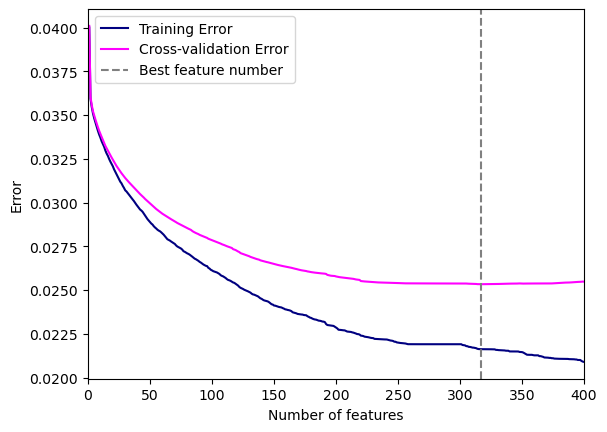

In [105]:
feature_num_lis = []
cv_error_lis = []
training_error_lis = []

for i in range(400):
    cv_error_lis.append(abs(subset_info[i+1]["avg_score"]))
    feature_num_lis.append(i+1)

    X_train_progress = X_train_final[:,subset_info[i+1]["feature_idx"]]
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_progress, y)
    y_pred = lin_reg.predict(X_train_progress)
    training_error_lis.append(mean_squared_error(y, y_pred))

fig,ax = plt.subplots()
ax.plot(feature_num_lis, training_error_lis, label= "Training Error", color = "navy")
ax.plot(feature_num_lis, cv_error_lis, label = "Cross-validation Error", color = "magenta")
ax.set(xlim=(0,400))
ax.set_ylabel("Error")
ax.set_xlabel("Number of features")
ax.axvline(x=len(sfs_reg.k_feature_names_), color='grey', linestyle='--', label='Best feature number')
ax.legend()
plt.show()

In [88]:
X_train_selected_final_stepwise = X_train_final[:, sfs_reg.k_feature_idx_]
X_train_selected_final_stepwise.shape

(1762, 317)

<a id="section17"></a>

## Model Fitting

For the candidate models, we selected only Random Forest, XGBoost, and LightGBM, as they outperformed the other models across all performance metrics for the tasks. We used the regression model as our baseline.

### Fitting with LASSO selected design matrix 

#### Linear regressor

In [89]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_selected_final_lasso, y)
print("SGD regression CV MSE:",
      multi_time_cv_mse(10, sgd_reg, X_train_selected_final_lasso),
      "\nSGD regression R^2:", r2_score(y, sgd_reg.predict(X_train_selected_final_lasso))
      )

SGD regression CV MSE: 0.03447557056836607 
SGD regression R^2: 0.4335349130508983


#### Random Forest regressor

In [90]:
rfg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rfg.fit(X_train_selected_final_lasso, y)

print("Random froest regression CV MSE:",
      multi_time_cv_mse(10, rfg, X_train_selected_final_lasso),
      "\nRandom froest regression R^2:", r2_score(y, rfg.predict(X_train_selected_final_lasso))
      )

Random froest regression CV MSE: 0.03316400838582475 
Random froest regression R^2: 0.9200047764627164


#### XG Boost regressor

In [91]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8)
xgb_reg.fit(X_train_selected_final_lasso, y)

print("XG Boost regression CV MSE:",
      multi_time_cv_mse(10, xgb_reg, X_train_selected_final_lasso),
      "\nXG Boost regression R^2:", r2_score(y, xgb_reg.predict(X_train_selected_final_lasso))
      )

XG Boost regression CV MSE: 0.03315865934296132 
XG Boost regression R^2: 0.868526107612859


#### Light GBM regressor

In [92]:
lgb_reg = LGBMRegressor(verbose=-1)
lgb_reg.fit(X_train_selected_final_lasso, y)

print("Light GBM regression CV MSE:",
      multi_time_cv_mse(10, lgb_reg, X_train_selected_final_lasso),
      "\nLight GBM regression R^2:", r2_score(y, lgb_reg.predict(X_train_selected_final_lasso))
      )

Light GBM regression CV MSE: 0.03390612585215859 
Light GBM regression R^2: 0.8727698615314459


#### Linear classifier

In [93]:
sgd_classifer = SGDClassifier()

print('Logistic classifier cv accuracy:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_lasso, "accuracy"))
print('Logistic classifier cv precision:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_lasso, "precision"))
print('Logistic classifier cv recall:', multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_lasso, "recall"))
print('Logistic classifier cv F1 score:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_lasso, "f1"))
print('Logistic classifier cv AUC:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_lasso, "roc_auc"))

Logistic classifier cv accuracy: 0.8397128508884883
Logistic classifier cv precision: 0.4997529245576374
Logistic classifier cv recall: 0.36859607843137254
Logistic classifier cv F1 score: 0.3747187205056549
Logistic classifier cv AUC: 0.7957696982011656


#### Random Forest classifier

In [94]:
rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')

print('Random Forest classifier cv accuracy:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_lasso, "accuracy"))
print('Random Forest classifier cv precision:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_lasso, "precision"))
print('Random Forest classifier cv recall:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_lasso, "recall"))
print('Random Forest classifier cv F1 score:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_lasso, "f1"))
print('Random Forest classifier cv AUC:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_lasso, "roc_auc"))

Random Forest classifier cv accuracy: 0.8797361898016997
Random Forest classifier cv precision: 0.7155945995238564
Random Forest classifier cv recall: 0.29265882352941175
Random Forest classifier cv F1 score: 0.4038393301203859
Random Forest classifier cv AUC: 0.8423992764023829


#### XG Boost classifier

In [95]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=None, subsample=0.8)

print('XG Boost classifier cv accuracy:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_lasso, "accuracy"))
print('XG Boost classifier cv precision:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_lasso, "precision"))
print('XG Boost classifier cv recall:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_lasso, "recall"))
print('XG Boost classifier cv F1 score:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_lasso, "f1"))
print('XG Boost classifier cv AUC:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_lasso, "roc_auc"))

XG Boost classifier cv accuracy: 0.8819372907545711
XG Boost classifier cv precision: 0.6552606813476378
XG Boost classifier cv recall: 0.3989019607843137
XG Boost classifier cv F1 score: 0.49153499553051255
XG Boost classifier cv AUC: 0.8505087745863784


#### Light GBM classifier

In [96]:
lgb_clf = LGBMClassifier(verbose = -1)

print('Light GBM classifier cv accuracy:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_lasso, "accuracy"))
print('Light GBM classifier cv precision:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_lasso, "precision"))
print('Light GBM classifier cv recall:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_lasso, "recall"))
print('Light GBM classifier cv F1 score:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_lasso, "f1"))
print('Light GBM classifier cv AUC:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_lasso, "roc_auc"))

Light GBM classifier cv accuracy: 0.8819469482359


Light GBM classifier cv precision: 0.6643223443223443
Light GBM classifier cv recall: 0.3872941176470587
Light GBM classifier cv F1 score: 0.4841989664082688
Light GBM classifier cv AUC: 0.8577590389305267


### Fitting with foward-stepwise matrix

#### Linear regressor

In [97]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_selected_final_stepwise, y)
print("SGD regression CV MSE:",
      multi_time_cv_mse(10, sgd_reg, X_train_selected_final_stepwise),
      "\nSGD regression R^2:", r2_score(y, sgd_reg.predict(X_train_selected_final_stepwise))
      )

SGD regression CV MSE: 0.03248899206434739 
SGD regression R^2: 0.46194834017112074


#### Random Forest regressor

In [98]:
rfg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rfg.fit(X_train_selected_final_stepwise, y)

print("Random froest regression CV MSE:",
      multi_time_cv_mse(10, rfg, X_train_selected_final_stepwise),
      "\nRandom froest regression R^2:", r2_score(y, rfg.predict(X_train_selected_final_stepwise))
      )

Random froest regression CV MSE: 0.03347240743819772 
Random froest regression R^2: 0.9189939867157387


#### XG Boost regressor

In [99]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8)
xgb_reg.fit(X_train_selected_final_stepwise, y)

print("XG Boost regression CV MSE:",
      multi_time_cv_mse(10, xgb_reg, X_train_selected_final_stepwise),
      "\nXG Boost regression R^2:", r2_score(y, xgb_reg.predict(X_train_selected_final_stepwise))
      )

XG Boost regression CV MSE: 0.03149286119687507 
XG Boost regression R^2: 0.8120672703561762


#### Light GBM regressor

In [100]:
lgb_reg = LGBMRegressor(verbose=-1)
lgb_reg.fit(X_train_selected_final_stepwise, y)

print("Light GBM regression CV MSE:",
      multi_time_cv_mse(10, lgb_reg, X_train_selected_final_stepwise),
      "\nLight GBM regression R^2:", r2_score(y, lgb_reg.predict(X_train_selected_final_stepwise))
      )

Light GBM regression CV MSE: 0.03292361459966066 
Light GBM regression R^2: 0.8517107094040806


#### Linear classifier

In [101]:
sgd_classifer = SGDClassifier()

print('Logistic classifier cv accuracy:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_stepwise, "accuracy"))
print('Logistic classifier cv precision:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_stepwise, "precision"))
print('Logistic classifier cv recall:', multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_stepwise, "recall"))
print('Logistic classifier cv F1 score:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_stepwise, "f1"))
print('Logistic classifier cv AUC:',multi_time_cv_scroe(10, sgd_classifer, X_train_selected_final_stepwise, "roc_auc"))

Logistic classifier cv accuracy: 0.8501641771825907
Logistic classifier cv precision: 0.5101221219563155
Logistic classifier cv recall: 0.42179607843137246
Logistic classifier cv F1 score: 0.4596708790546241
Logistic classifier cv AUC: 0.8063406464449325


#### Random Forest classifier

In [102]:
rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')

print('Random Forest classifier cv accuracy:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_stepwise, "accuracy"))
print('Random Forest classifier cv precision:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_stepwise, "precision"))
print('Random Forest classifier cv recall:', multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_stepwise, "recall"))
print('Random Forest classifier cv F1 score:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_stepwise, "f1"))
print('Random Forest classifier cv AUC:',multi_time_cv_scroe(10, rdf_clf, X_train_selected_final_stepwise, "roc_auc"))

Random Forest classifier cv accuracy: 0.8753101661086788
Random Forest classifier cv precision: 0.7094015476267799
Random Forest classifier cv recall: 0.2351372549019608
Random Forest classifier cv F1 score: 0.33812042345285714
Random Forest classifier cv AUC: 0.8293274097379596


#### XG Boost classifier

In [103]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=None, subsample=0.8)

print('XG Boost classifier cv accuracy:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_stepwise, "accuracy"))
print('XG Boost classifier cv precision:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_stepwise, "precision"))
print('XG Boost classifier cv recall:', multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_stepwise, "recall"))
print('XG Boost classifier cv F1 score:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_stepwise, "f1"))
print('XG Boost classifier cv AUC:',multi_time_cv_scroe(10, xgb_clf, X_train_selected_final_stepwise, "roc_auc"))

XG Boost classifier cv accuracy: 0.8813755472572753
XG Boost classifier cv precision: 0.6478566599053412
XG Boost classifier cv recall: 0.3872941176470589
XG Boost classifier cv F1 score: 0.4844117647058823
XG Boost classifier cv AUC: 0.858950097087965


#### Light GBM classifier

In [104]:
lgb_clf = LGBMClassifier(verbose = -1)

print('Light GBM classifier cv accuracy:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_stepwise, "accuracy"))
print('Light GBM classifier cv precision:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_stepwise, "precision"))
print('Light GBM classifier cv recall:', multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_stepwise, "recall"))
print('Light GBM classifier cv F1 score:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_stepwise, "f1"))
print('Light GBM classifier cv AUC:',multi_time_cv_scroe(10, lgb_clf, X_train_selected_final_stepwise, "roc_auc"))

Light GBM classifier cv accuracy: 0.8813739376770539
Light GBM classifier cv precision: 0.6437369082530371
Light GBM classifier cv recall: 0.39521568627450987
Light GBM classifier cv F1 score: 0.48927178909423424
Light GBM classifier cv AUC: 0.8598329232817413


<a id="section18"></a>

## Summarizing Table

<table>
  <tr>
    <th>Design matrix</th>
    <th>Models</th>
    <th>cv MSE</th>
    <th>R<sup>2</sup></th>
  </tr>
  <tr>
    <td rowspan="4">LASSO regression selected design matrix</td>
    <td>Linear regression</td>
    <td>0.0345</td>
    <td>0.434</td>
  </tr>

  <tr>
    <td>Random Forest</td>
    <td>0.0332</td>
    <td>0.920</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.0332</td>
    <td>0.869</td>
  </tr>
  <tr>
    <td>Light GBM</td>
    <td>0.0339</td>
    <td>0.873</td>
  </tr>


  <tr>
    <td rowspan="4">Forward-stepwise regression selected design matrix</td>
    <td>Linear regression</td>
    <td>0.0325</td>
    <td>0.462</td>
  </tr>

  <tr>
    <td>Random Forest</td>
    <td>0.0335</td>
    <td>0.919</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.0315</td>
    <td>0.812</td>
  </tr>
  <tr>
    <td>Light GBM</td>
    <td>0.0329</td>
    <td>0.852</td>
  </tr>
</table>

<table>
  <tr>
    <th>Design matrix</th>
    <th>Models</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1 Score</th>
    <th>AUC</th>
  </tr>
  <tr>
    <td rowspan="4">LASSO regression selected design matrix</td>
    <td>Logistic regression</td>
    <td>0.840</td>
    <td>0.500</td>
    <td>0.369</td>
    <td>0.375</td>
    <td>0.796</td>
  </tr>

  <tr>
    <td>Random Forest</td>
    <td>0.880</td>
    <td>0.716</td>
    <td>0.293</td>
    <td>0.404</td>
    <td>0.842</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.882</td>
    <td>0.655</td>
    <td>0.399</td>
    <td>0.492</td>
    <td>0.851</td>
  </tr>

  <tr>
   <td>Light GBM</td>
   <td>0.882</td>
   <td>0.664</td>
   <td>0.387</td>
   <td>0.484</td>
   <td>0.858</td>
  </tr>


  <tr>
    <td rowspan="4">Forward-stepwise regression selected design matrix</td>
    <td>Logistic regression</td>
    <td>0.850</td>
    <td>0.510</td>
    <td>0.422</td>
    <td>0.460</td>
    <td>0.806</td>
  </tr>

  <tr>
    <td>Random Forest</td>
    <td>0.875</td>
    <td>0.709</td>
    <td>0.235</td>
    <td>0.338</td>
    <td>0.829</td>
  </tr>
  <tr>
    <td>XG Boost</td>
    <td>0.881</td>
    <td>0.648</td>
    <td>0.387</td>
    <td>0.484</td>
    <td>0.859</td>
  </tr>

  <tr>
    <td>Light GBM</td>
    <td>0.881</td>
    <td>0.644</td>
    <td>0.395</td>
    <td>0.489</td>
    <td>0.860</td>
  </tr>
</table>

We presented these results visually to better highlight the performance differences among models.

In [2]:
lasso_reg_measure = {}
lasso_reg_measure["LR"] = [0.0349, 0.418] # mse, R^2
lasso_reg_measure["RF"] = [0.0331, 0.921]
lasso_reg_measure["XGB"] = [0.0333, 0.857]
lasso_reg_measure["LGB"] = [0.0350, 0.864]

stepwise_reg_measure ={}
stepwise_reg_measure["LR"] = [0.0335, 0.437]
stepwise_reg_measure["RF"] = [0.0326, 0.920]
stepwise_reg_measure["XGB"] = [0.0321, 0.789]
stepwise_reg_measure["LGB"] = [0.0344, 0.817]

lasso_clf_measure = {}
lasso_clf_measure["LR"] = [0.851, 0.478, 0.408, 0.407, 0.791] # Acu, P, R, F1, AUC
lasso_clf_measure["RF"] = [0.878, 0.689, 0.310, 0.420, 0.846]
lasso_clf_measure["XGB"] = [0.877, 0.630, 0.383, 0.474, 0.849]
lasso_clf_measure["LGB"] = [0.881, 0.650, 0.395, 0.487, 0.848]

stwpwise_clf_measure = {}
stwpwise_clf_measure["LR"] = [0.862, 0.519, 0.474, 0.480, 0.819]
stwpwise_clf_measure["RF"] = [0.883, 0.704, 0.315, 0.442, 0.836]
stwpwise_clf_measure["XGB"] = [0.880, 0.632, 0.407, 0.494, 0.864]
stwpwise_clf_measure["LGB"] = [0.880, 0.626, 0.439, 0.511, 0.864]



In [3]:
lasso_reg_measure_cluster = {}
lasso_reg_measure_cluster["LR"] = [0.0345, 0.434] # mse, R^2
lasso_reg_measure_cluster["RF"] = [0.0332, 0.920]
lasso_reg_measure_cluster["XGB"] = [0.0332, 0.869]
lasso_reg_measure_cluster["LGB"] = [0.0339, 0.873]

stepwise_reg_measure_cluster ={}
stepwise_reg_measure_cluster["LR"] = [0.0325, 0.462]
stepwise_reg_measure_cluster["RF"] = [0.0335, 0.919]
stepwise_reg_measure_cluster["XGB"] = [0.0315, 0.812]
stepwise_reg_measure_cluster["LGB"] = [0.0329, 0.852]

lasso_clf_measure_cluster = {}
lasso_clf_measure_cluster["LR"] = [0.840, 0.500, 0.369, 0.375, 0.796] # Acu, P, R, F1, AUC
lasso_clf_measure_cluster["RF"] = [0.880, 0.716, 0.293, 0.404, 0.842]
lasso_clf_measure_cluster["XGB"] = [0.882, 0.655, 0.399, 0.492, 0.851]
lasso_clf_measure_cluster["LGB"] = [0.882, 0.664, 0.387, 0.484, 0.858]

stwpwise_clf_measure_cluster = {}
stwpwise_clf_measure_cluster["LR"] = [0.850, 0.510, 0.422, 0.460, 0.806]
stwpwise_clf_measure_cluster["RF"] = [0.875, 0.709, 0.235, 0.338, 0.829]
stwpwise_clf_measure_cluster["XGB"] = [0.881, 0.648, 0.387, 0.484, 0.859]
stwpwise_clf_measure_cluster["LGB"] = [0.881, 0.644, 0.395, 0.489, 0.860]



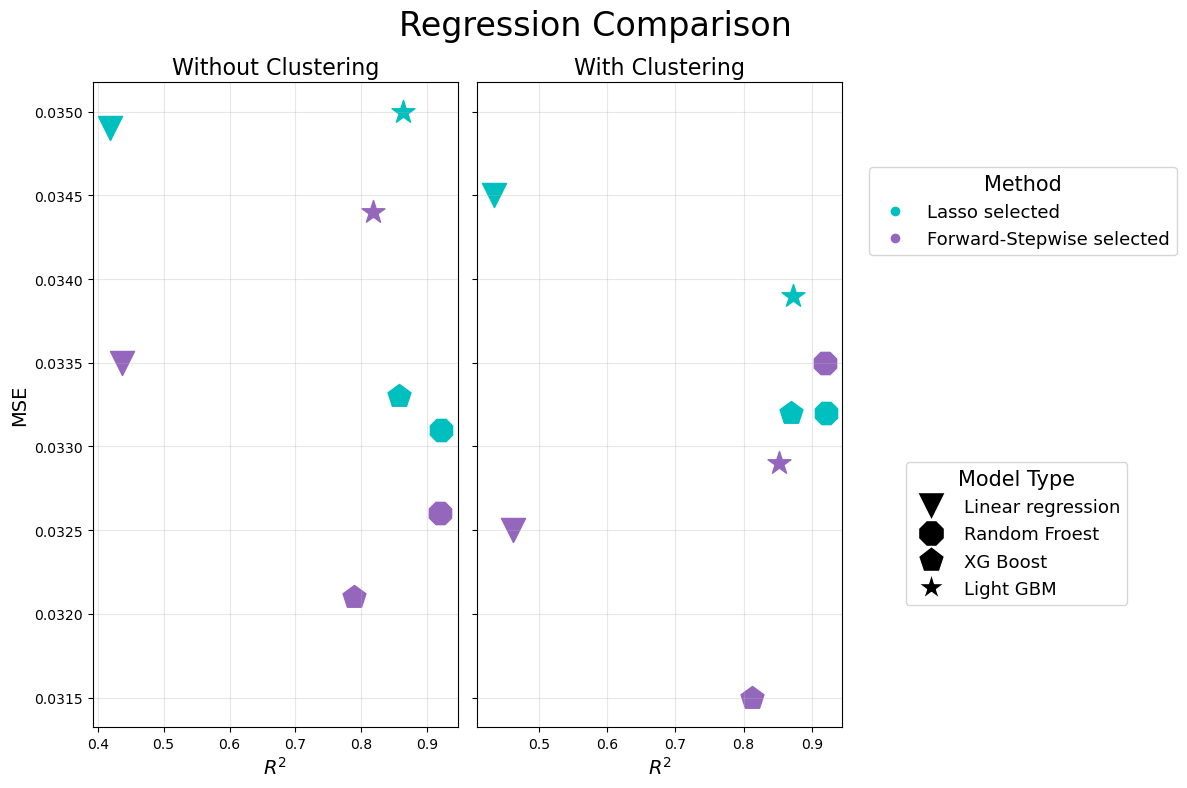

In [17]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (12, 8))

# data drawing
ax[0].scatter(lasso_reg_measure["LR"][1], lasso_reg_measure["LR"][0], marker='v', c='c', s=300)
ax[0].scatter(lasso_reg_measure["RF"][1], lasso_reg_measure["RF"][0], marker='8', c='c', s=300)
ax[0].scatter(lasso_reg_measure["XGB"][1], lasso_reg_measure["XGB"][0], marker='p', c='c', s=300)
ax[0].scatter(lasso_reg_measure["LGB"][1], lasso_reg_measure["LGB"][0], marker='*', c='c', s=300)

ax[0].scatter(stepwise_reg_measure["LR"][1], stepwise_reg_measure["LR"][0], marker='v', c='#9467BD', s=300)
ax[0].scatter(stepwise_reg_measure["RF"][1], stepwise_reg_measure["RF"][0], marker='8', c='#9467BD', s=300)
ax[0].scatter(stepwise_reg_measure["XGB"][1], stepwise_reg_measure["XGB"][0], marker='p', c='#9467BD', s=300)
ax[0].scatter(stepwise_reg_measure["LGB"][1], stepwise_reg_measure["LGB"][0], marker='*', c='#9467BD', s=300)

ax[1].scatter(lasso_reg_measure_cluster["LR"][1], lasso_reg_measure_cluster["LR"][0], marker='v', c='c', s=300)
ax[1].scatter(lasso_reg_measure_cluster["RF"][1], lasso_reg_measure_cluster["RF"][0], marker='8', c='c', s=300)
ax[1].scatter(lasso_reg_measure_cluster["XGB"][1], lasso_reg_measure_cluster["XGB"][0], marker='p', c='c', s=300)
ax[1].scatter(lasso_reg_measure_cluster["LGB"][1], lasso_reg_measure_cluster["LGB"][0], marker='*', c='c', s=300)

ax[1].scatter(stepwise_reg_measure_cluster["LR"][1], stepwise_reg_measure_cluster["LR"][0], marker='v', c='#9467BD', s=300)
ax[1].scatter(stepwise_reg_measure_cluster["RF"][1], stepwise_reg_measure_cluster["RF"][0], marker='8', c='#9467BD', s=300)
ax[1].scatter(stepwise_reg_measure_cluster["XGB"][1], stepwise_reg_measure_cluster["XGB"][0], marker='p', c='#9467BD', s=300)
ax[1].scatter(stepwise_reg_measure_cluster["LGB"][1], stepwise_reg_measure_cluster["LGB"][0], marker='*', c='#9467BD', s=300)

# --- 手动创建图例句柄 ---
marker_handles = [
    Line2D([0], [0], marker='v', color='w', label='Linear regression', markerfacecolor='k', markersize=20),
    Line2D([0], [0], marker='8', color='w', label='Random Froest', markerfacecolor='k', markersize=20),
    Line2D([0], [0], marker='p', color='w', label='XG Boost', markerfacecolor='k', markersize=20),
    Line2D([0], [0], marker='*', color='w', label='Light GBM', markerfacecolor='k', markersize=20)
]

color_handles = [
    Line2D([0], [0], marker='o', color='w', label='Lasso selected', markerfacecolor='c', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Forward-Stepwise selected', markerfacecolor='#9467BD', markersize=8)
]

# --- 分别加两个图例 ---
legend1 = ax[1].legend(handles=marker_handles, title="Model Type", loc='upper right')
legend2 = ax[1].legend(handles=color_handles, title="Method", loc='lower right')

legend1 = ax[1].legend(
    handles=marker_handles,
    title="Model Type",
    loc='center left',
    bbox_to_anchor=(1.15, 0.3),  # 图外右侧居中
    fontsize= 13,
    title_fontsize = 15
)

legend2 = ax[1].legend(
    handles=color_handles,
    title="Method",
    loc='center left',
    bbox_to_anchor=(1.05, 0.8),  # 再往右一点
    fontsize= 13,
    title_fontsize = 15
)

# 为了让两个 legend 都显示，需要手动添加第一个 legend
ax[1].add_artist(legend1)

ax[0].set_ylabel('MSE', fontsize= 14)
ax[0].set_xlabel('$R^2$', fontsize = 14)
ax[1].set_xlabel('$R^2$', fontsize = 14)
ax[0].set_title("Without Clustering", fontsize= 16)
ax[1].set_title("With Clustering", fontsize = 16)
fig.suptitle("Regression Comparison", fontsize = 24, horizontalalignment = "center")

ax[0].grid(True, alpha=0.3, linewidth=0.8)
ax[1].grid(True, alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

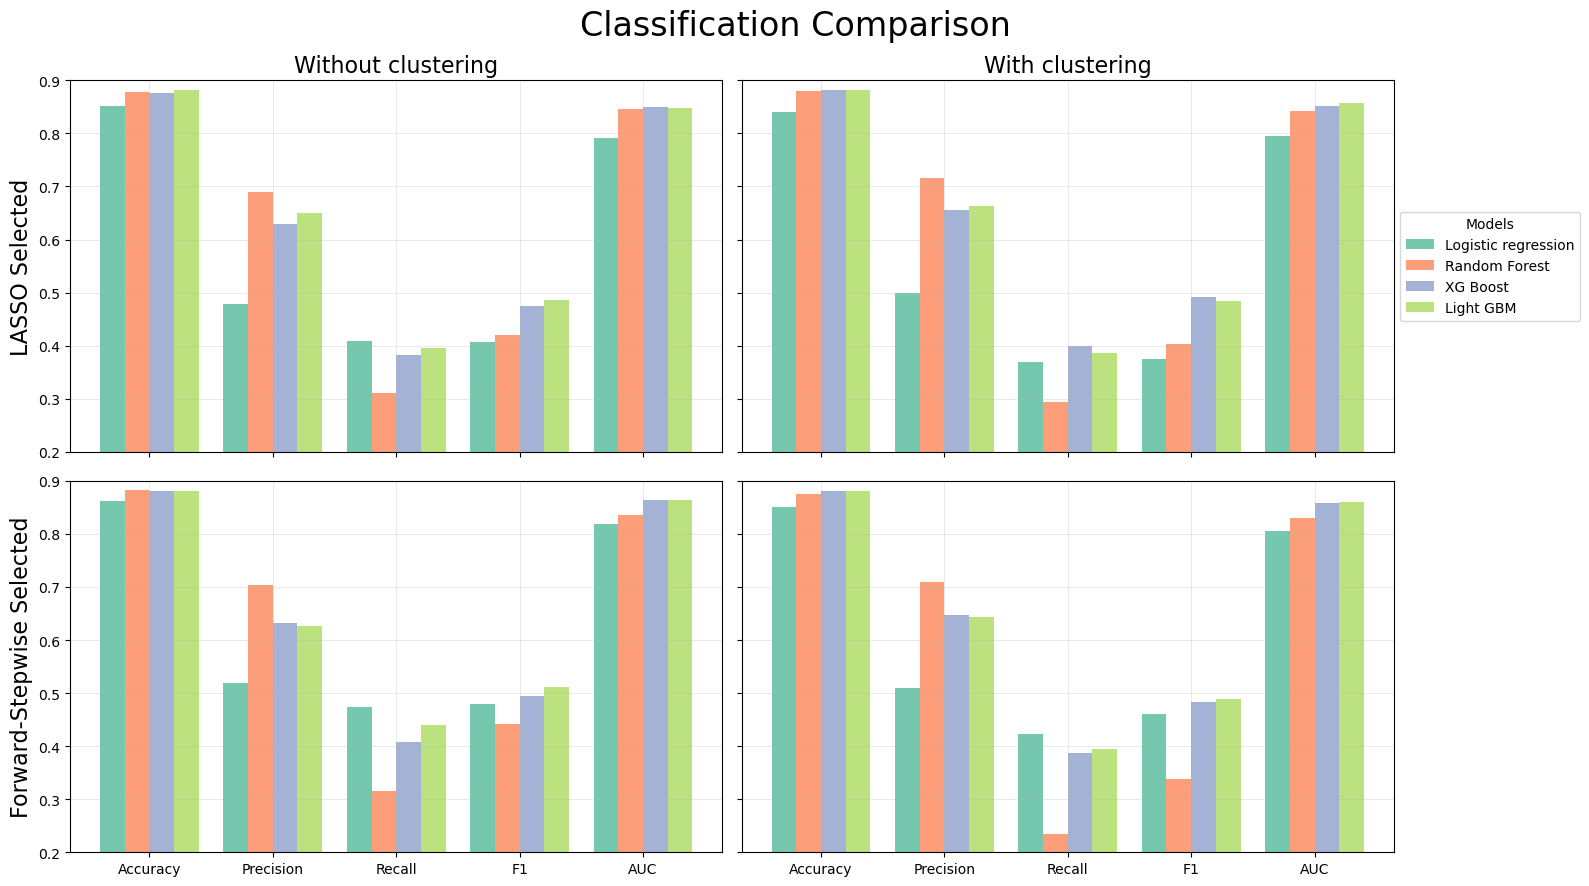

In [16]:
labels = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
x = np.arange(len(labels))  # 横坐标位置

width = 0.2  # 每个柱子的宽度

fig, ax = plt.subplots(2, 2, figsize=(16,9),sharex=True, sharey=True)

ax[0,0].bar(x - width*1.5, lasso_clf_measure["LR"], width, label='Logistic regression', color='#66c2a5', alpha=0.9)
ax[0,0].bar(x - width*0.5, lasso_clf_measure["RF"], width, label='Random Forest', color='#fc8d62', alpha=0.85)
ax[0,0].bar(x + width*0.5, lasso_clf_measure["XGB"], width, label='XG Boost', color='#8da0cb', alpha=0.8)
ax[0,0].bar(x + width*1.5, lasso_clf_measure["LGB"], width, label='Light GBM', color= '#a6d854', alpha=0.75)

ax[0,0].set_ylabel("LASSO Selected", fontsize = 16)
ax[0,0].set_title("Without clustering", fontsize = 16)

ax[0,0].set_xticks(x)               # 对应位置
ax[0,0].set_xticklabels(labels)     # 自定义标签

ax[0,1].bar(x - width*1.5, lasso_clf_measure_cluster["LR"], width, label='Logistic regression', color='#66c2a5', alpha=0.9)
ax[0,1].bar(x - width*0.5, lasso_clf_measure_cluster["RF"], width, label='Random Forest', color='#fc8d62', alpha=0.85)
ax[0,1].bar(x + width*0.5, lasso_clf_measure_cluster["XGB"], width, label='XG Boost', color='#8da0cb', alpha=0.8)
ax[0,1].bar(x + width*1.5, lasso_clf_measure_cluster["LGB"], width, label='Light GBM', color= '#a6d854', alpha=0.75)

ax[0,1].set_title("With clustering", fontsize = 16)

ax[1,0].bar(x - width*1.5, stwpwise_clf_measure["LR"], width, label='Logistic regression', color='#66c2a5', alpha=0.9)
ax[1,0].bar(x - width*0.5, stwpwise_clf_measure["RF"], width, label='Random Forest', color='#fc8d62', alpha=0.85)
ax[1,0].bar(x + width*0.5, stwpwise_clf_measure["XGB"], width, label='XG Boost', color='#8da0cb', alpha=0.8)
ax[1,0].bar(x + width*1.5, stwpwise_clf_measure["LGB"], width, label='Light GBM', color= '#a6d854', alpha=0.75)

ax[1,0].set_ylabel("Forward-Stepwise Selected", fontsize = 16)

ax[1,1].bar(x - width*1.5, stwpwise_clf_measure_cluster["LR"], width, label='Logistic regression', color='#66c2a5', alpha=0.9)
ax[1,1].bar(x - width*0.5, stwpwise_clf_measure_cluster["RF"], width, label='Random Forest', color='#fc8d62', alpha=0.85)
ax[1,1].bar(x + width*0.5, stwpwise_clf_measure_cluster["XGB"], width, label='XG Boost', color='#8da0cb', alpha=0.8)
ax[1,1].bar(x + width*1.5, stwpwise_clf_measure_cluster["LGB"], width, label='Light GBM', color= '#a6d854', alpha=0.75)

ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Models')

fig.suptitle("Classification Comparison", fontsize = 24, horizontalalignment = "center")
ax[0,0].set_ylim(0.2,0.9)
ax[0,0].grid(True, alpha=0.4, linewidth=0.5)
ax[0,1].grid(True, alpha=0.4, linewidth=0.5)
ax[1,0].grid(True, alpha=0.4, linewidth=0.5)
ax[1,1].grid(True, alpha=0.4, linewidth=0.5)

#for a in ax.ravel():
#    a.axhline(y=0.878, color="red", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Based on the regression comparison plot, we observed that the MSE of most models improved, with Random Forest being the exception. Comparing markers of the same color and shape across the two plots, we found that the y-axis differences were larger for the purple markers than for the cyan ones. This indicates that applying the K-mean clustering algotirhm led to more significant improvements for models trained on the forward-stepwise–selected matrix than for those trained on the LASSO-selected matrix. Additionally, markers in the right plot were shifted further to the right on the x-axis compared to their counterparts of the same color and shape, suggesting that the method also improved $R^2$.

However, for the classification task, incorporating K-Means clustering did not improve model performance across all metrics. The method generally improved precision for each model, but at the cost of lower recall. XGBoost was an exception: its accuracy and recall could also improve depending on the design matrix it was trained on. For the other models, accuracy was largely unaffected, fluctuating only within a small range. AUC values either increased or decreased depending on the design matrix used.

Additionally, we observed that clustering provided less benefit for models trained on the forward-stepwise–selected matrix compared to those trained on the LASSO-selected matrix. For example, the improvement in the precision of Random Forest trained on the LASSO-selected matrix was more significant than that of the model trained on the forward-stepwise–selected matrix, and the trade-offs between metrics were also more severe in these cases.

<a id="section19"></a>

# Conclusion